### Step 0: Have some drawing function to visualize what you're doing...

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import torch
from torch_geometric.data import Data

# Mapping from one-hot index to color name and matplotlib color
IDX2COLOR = {
    0: ('R', 'red'),
    1: ('G', 'green'),
    2: ('B', 'blue'),
    3: ('W', 'white'),
    4: ('X', 'gray'),
}

COLOR2IDX = {'R':0,'G':1,'B':2,'W':3,'X':4}

def draw_color_graph(graph: Data):
    G = to_networkx(graph, node_attrs=['x'], to_undirected=True)

    # Try planar layout if the graph is planar
    if nx.check_planarity(G)[0]:
        pos = nx.planar_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)  # fallback

    node_labels = []
    node_colors = []

    for i in range(graph.num_nodes):
        idx = int(graph.x[i].item())
        label, color = IDX2COLOR[idx]
        node_labels.append(label)
        node_colors.append(color)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, edgecolors='black', linewidths=1.5)
    nx.draw_networkx_edges(G, pos, width=1.5)

    label_dict = {i: node_labels[i] for i in range(graph.num_nodes)}
    nx.draw_networkx_labels(G, pos, labels=label_dict, font_size=16, font_color='black')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=label) for idx, (label, color) in IDX2COLOR.items()]
    plt.legend(handles=legend_elements, loc='upper left', frameon=True)

    plt.axis('off')
    plt.tight_layout()
    plt.show()

Now let's create a basic simple dataset using many data objects.

In [2]:
from torch_geometric.utils import to_undirected
import random
from torch_geometric.data import InMemoryDataset


from torch_geometric.data import Data

class HashableData(Data):
    def __eq__(self, other):
        if not isinstance(other, Data):
            return False
        return (
                torch.equal(self.x, other.x) and
                torch.equal(self.edge_index, other.edge_index)
        )

    def __hash__(self):
        x_hash = hash(self.x.cpu().numpy().tobytes())
        ei_hash = hash(self.edge_index.cpu().numpy().tobytes())
        return hash((x_hash, ei_hash))

torch.serialization.add_safe_globals([HashableData])
class ColorGraphDataset(InMemoryDataset):
    def __init__(self,
                 root,
                 num_graphs=100,
                 min_nodes=5,
                 max_nodes=15,
                 edge_p=0.15,
                 transform=None,
                 pre_transform=None):
        self.num_graphs, self.min_nodes, self.max_nodes = num_graphs, min_nodes, max_nodes
        self.edge_p = edge_p
        super().__init__(root, transform, pre_transform)
        self.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    def process(self):
        motif_centric_collections = []
        motif_centrics = set()
        motifs = [self.ring_motif, self.triangle_motif]
        for i, motif_func in enumerate(motifs):
            # Ensure Evenly distributed motifs
            while len(motif_centrics) < self.num_graphs // len(motifs) :
                base_colors, base_edges = motif_func()
                extra_nodes = random.randint(1, 5)
                total_colors, total_edges = self.expand_graph_planar(base_colors, base_edges, extra_nodes, )

                # Add node features
                x = torch.tensor([[COLOR2IDX[c]] for c in total_colors], dtype=torch.float)

                # Add edges
                edge_index = torch.tensor(total_edges, dtype=torch.long).t().contiguous()
                edge_index = to_undirected(edge_index, num_nodes=len(total_colors))

                data = HashableData(x=x, edge_index=edge_index)
                data.validate(raise_on_error=True)
                motif_centrics.add(data)

            motif_centric_collections.append(motif_centrics)
            motif_centrics = set()

        motif_centric_collections = [g for mfs in motif_centric_collections for g in mfs]
        if self.pre_filter is not None:
            motif_centric_collections = [graph for part in motif_centric_collections for graph in part if self.pre_filter(graph)]
        if self.pre_transform is not None:
            motif_centric_collections = [self.pre_transform(d) for d in motif_centric_collections]

        self.save(motif_centric_collections, self.processed_paths[0])

    @staticmethod
    def ring_motif():
        colors = ['R', 'G', 'R', 'G', 'R']
        nodes = list(range(5))
        edges = [(i, (i + 1) % 5) for i in nodes]
        return colors, edges

    @staticmethod
    def triangle_motif():
        colors = ['R', 'G', 'B']
        edges = [(0, 1), (1, 2), (2, 0)]
        return colors, edges

    @staticmethod
    def expand_graph_planar(base_colors, base_edges, num_extra_nodes, max_attempts=100):
        n0 = len(base_colors)
        G = nx.Graph()
        G.add_nodes_from(range(n0))
        G.add_edges_from(base_edges)

        colors = base_colors[:]
        edges = base_edges[:]

        for i in range(num_extra_nodes):
            new_node_id = n0 + i
            G.add_node(new_node_id)
            new_color = random.choice(list(set(COLOR2IDX.keys()).difference(set(base_colors))))
            colors.append(new_color)

            attempts = 0
            while attempts < max_attempts:
                # Connect to 1–3 existing nodes
                k = random.randint(1, min(3, n0 + i))
                targets = random.sample(sorted(G.nodes - {new_node_id}), k)
                trial_edges = [(new_node_id, t) for t in targets]

                G.add_edges_from(trial_edges)
                is_planar, _ = nx.check_planarity(G)
                if is_planar:
                    edges.extend(trial_edges)
                    break
                else:
                    G.remove_edges_from(trial_edges)
                    attempts += 1

        return colors, edges

Use the generated Dataset

In [3]:
from pathlib import Path

root = Path.cwd()
project_dir = root.resolve().parent
datasets = project_dir / "datasets"

100


Processing...
Done!


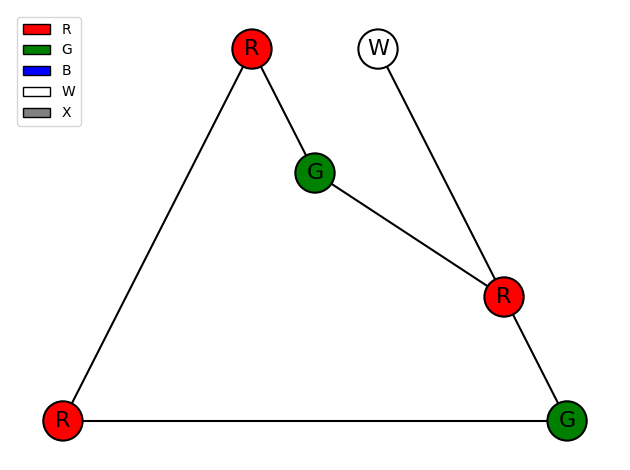

None


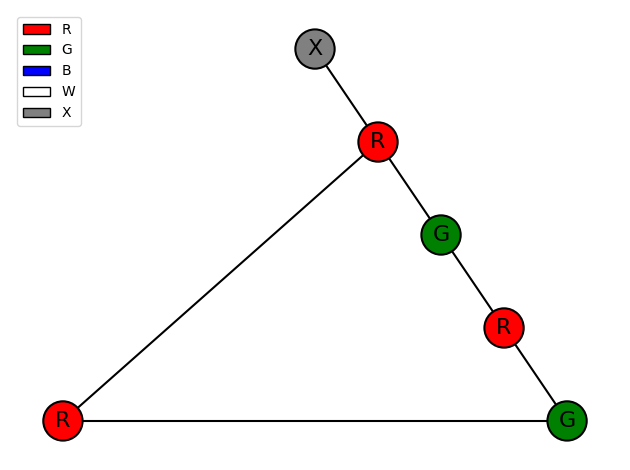

None


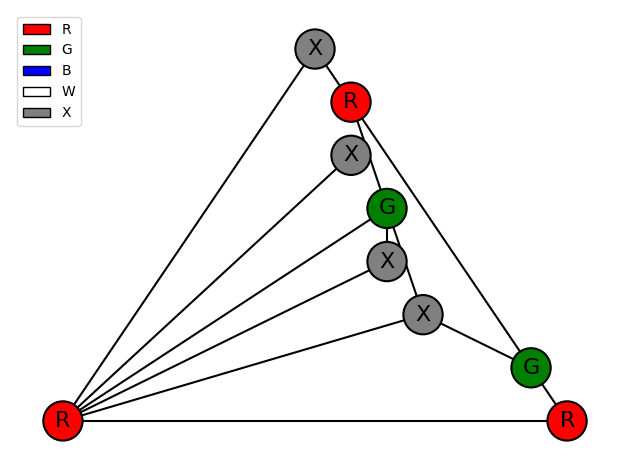

None


In [4]:
# usage
root = datasets / 'test' / 'ColorPlanar01'
dataset = ColorGraphDataset(root=root, num_graphs=100)
print(len(dataset))
print(draw_color_graph(dataset[10]))
print(draw_color_graph(dataset[1]))
print(draw_color_graph(dataset[2]))

In [5]:
a = {"R", "G", "B"}
# b = set("RGBXW")
# print(a)
# print(b)
# print(b.difference(a))
# random.randint(1, min(3, 5))
# list(set('RGBWX').difference(set(a)))
set(COLOR2IDX.keys()).difference(set(a))

{'W', 'X'}